# Predict whether the client has subscribed a term deposit or not.

## Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,roc_auc_score,roc_curve

In [3]:
# Matplotlib configurations

# Display interactive plots. Used this since convenient for displaying plots in github.
# %matplotlib notebook
# Font and figure size:
# Ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Import dataset

In [4]:
bank_df = pd.read_csv('bank-full.csv',sep=';') # Seperator is ';' instead of ','

In [5]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## EDA

In [6]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Observations:
- Data is from a campaign conducted by the bank, to get their customers to make term deposits.
- Data contains information regarding the banks's customers i.e their personal details, bank related details, campaign details and corresponding outcome; whether the customer made a term deposit. It is a mix of numeric and categorical variables.
- There are six different kinds of variables in this dataset
    - Cyclic (numeric and cat) - "day" and "month"
    - Interval (numeric) - "age", "duration", "campaign", "pdays"
    - Categorical; ordinal - "education"
    - Categorical; Label; binary - "default", "housing", "loan", "y"
    - Categorical; nominal - "job", "marital", "contact", "poutcome"
    - Numeric - "previous", "balance"
- We must use different encoding techniques in order to properly process the dataset.
- There are no null values.

In [7]:
# Extracting column names and sorting them to appropriate categories.
n_cols = len(bank_df.columns)
numeric_cols = []
cat_cols = []
for i in range(n_cols):
    if bank_df.dtypes[i] == 'int64':
        numeric_cols.append(bank_df.columns[i])
    else:
        cat_cols.append(bank_df.columns[i])

X_cols = [col for col in bank_df.columns if col not in ("y")]
y_col = "y"

print("Numeric columns      : ",numeric_cols)
print("Categorical columns  : ",cat_cols)

cat_cols.remove("y")

print("Categorical features : " ,cat_cols)
print("Features             : ",X_cols)
print("Target               : ",y_col)

Numeric columns      :  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns  :  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
Categorical features :  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Features             :  ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Target               :  y


## Model building

In [8]:
# Separating features and target.
X = bank_df.drop(['y'],axis=1)
y = bank_df['y']

In [9]:
# Spliiting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30291, 16), (14920, 16), (30291,), (14920,))

In [10]:
# Encode categorical features.
ordinal_enc = OrdinalEncoder()
X_train_enc = pd.DataFrame(ordinal_enc.fit_transform(X_train[cat_cols]))
X_test_enc = pd.DataFrame(ordinal_enc.transform(X_test[cat_cols]))

# Encoding removes column names, thus we need to insert them back
X_train_enc.columns = X_train[cat_cols].columns
X_test_enc.columns = X_test[cat_cols].columns

In [11]:
# Dropping corresponding categorical columns.
X_train.drop(cat_cols, axis=1, inplace=True)
X_test.drop(cat_cols, axis=1, inplace=True)

# Concatenating the encoded columns with the original data.
X_train = pd.concat([X_train, X_train_enc.set_index(X_train.index)], axis=1)
X_test = pd.concat([X_test, X_test_enc.set_index(X_test.index)], axis=1)

In [12]:
# Encoding the target variable.
label_enc = LabelEncoder()
y_train_enc = label_enc.fit_transform(y_train)
y_test_enc = label_enc.transform(y_test)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model training

In [14]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train_enc)

LogisticRegression()

In [15]:
log_model.coef_

array([[ 0.07149251,  0.06902964, -0.03881063,  1.02909677, -0.39319337,
         0.36962832,  0.18706114,  0.02638061,  0.13285927,  0.14560422,
        -0.05506589, -0.50317089, -0.24899631, -0.56736305,  0.11462209,
         0.22960332]])

In [16]:
log_model.intercept_

array([-2.68050071])

## Model testing

In [17]:
y_pred_train = log_model.predict(X_train)
y_pred_test = log_model.predict(X_test)

### Predictions and evaluation for train data

In [18]:
print("Accuracy score:", accuracy_score(y_train_enc, y_pred_train))

Accuracy score: 0.8905945660427189


In [19]:
print("Confusion matrix:\n", confusion_matrix(y_train_enc, y_pred_train))

Confusion matrix:
 [[26218   529]
 [ 2785   759]]


In [20]:
print("Precision score: ", precision_score(y_train_enc, y_pred_train))

Precision score:  0.5892857142857143


In [21]:
print("Recall score: ", recall_score(y_train_enc, y_pred_train))

Recall score:  0.2141647855530474


In [22]:
print(classification_report(y_train_enc, y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     26747
           1       0.59      0.21      0.31      3544

    accuracy                           0.89     30291
   macro avg       0.75      0.60      0.63     30291
weighted avg       0.87      0.89      0.87     30291



#### ROC curve - train data

0.597193433267046


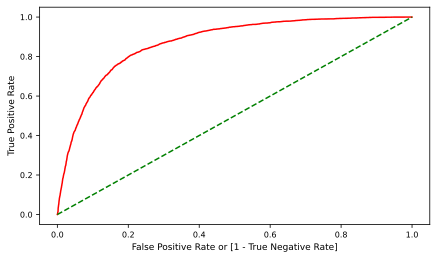

In [23]:
fpr, tpr, thresholds = roc_curve(y_train_enc, log_model.predict_proba (X_train)[:,1])

auc = roc_auc_score(y_train_enc,y_pred_train)
print(auc)

fig,ax = plt.subplots()
ax.plot(fpr, tpr, color='red', label='logit model ( area  = %0.2f)'%auc)
ax.plot([0, 1], [0, 1], 'g--')
ax.set_xlabel('False Positive Rate or [1 - True Negative Rate]')
ax.set_ylabel('True Positive Rate')
plt.show()

### Predictions and evaluation for test data

In [24]:
print("Accuracy score: ", accuracy_score(y_test_enc, y_pred_test))

Accuracy score:  0.8916890080428954


In [25]:
print("Confusion matrix:\n",confusion_matrix(y_test_enc, y_pred_test))

Confusion matrix:
 [[12931   244]
 [ 1372   373]]


For this problem, although the number of false negatives are more(as compared to false positives), it is good in a way since, bank could launch a much more vigorous campaign next year so that more customers would make term deposit. Also, the number of false positives is very less compared to true positives. Although this is the case there is a huge difference between precision and recall scores for 1 class. For a good model, this difference should be within 10%. Thus improvent has to be made with respect to getting the scores as close as possible. Since it is doing a good job predicting the 0 class, we can still use the model but it will not be reliable for predicting the 1 class (customers who subscribe to term deposit).

In [26]:
print("Precision score: ",precision_score(y_test_enc, y_pred_test))

Precision score:  0.6045380875202593


In [27]:
print("Recall score: ",recall_score(y_test_enc, y_pred_test))

Recall score:  0.21375358166189112


In [28]:
print(classification_report(y_test_enc, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     13175
           1       0.60      0.21      0.32      1745

    accuracy                           0.89     14920
   macro avg       0.75      0.60      0.63     14920
weighted avg       0.87      0.89      0.87     14920



#### ROC curve -test data:

0.5976168287816097


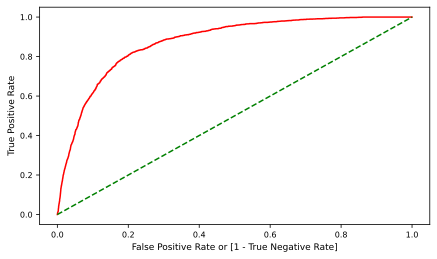

In [29]:
fpr, tpr, thresholds = roc_curve(y_test_enc, log_model.predict_proba (X_test)[:,1])

auc = roc_auc_score(y_test_enc,y_pred_test)
print(auc)

fig,ax = plt.subplots()
ax.plot(fpr, tpr, color='red', label='logit model ( area  = %0.2f)'%auc)
ax.plot([0, 1], [0, 1], 'g--')
ax.set_xlabel('False Positive Rate or [1 - True Negative Rate]')
ax.set_ylabel('True Positive Rate')
plt.show()

## Conclusion:
A logistic regression model was constructed to predict whether the client has subscribed to a term deposit or not.